# Anaĺise Unitária
## Abordagem com NeuroKit

In [5]:
import numpy as np
import pandas as pd
import neurokit2 as nk
from joblib import Parallel, delayed
import mne 
import os

In [2]:
PATH = os.path.abspath('../../')

df = pd.read_csv(PATH+'/data/Generalized_seizures_dataset.csv')

In [3]:
parts = [path.split("/") for path in df['path'].to_list()]

patients = []
sessions = []
files = []

for item in df['path'].to_list():
    part = item.split("/")
    patients.append(part[-3])
    sessions.append(part[-2])
    files.append(part[-1].replace('tse','edf'))

df['patients'] = patients
df['sessions'] = sessions
df['files'] = files


unique_patients = np.unique(patients)

In [6]:
# Função para carregar edf's
def load_edf(path):
    path_folder = '/media/davi/2526467b-9f07-4ce5-9425-6d2b458567b7/home/davi/www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.2/edf/'
    file = path.replace('tse', 'edf')
    data = mne.io.read_raw_edf(path_folder + file)
    info = data.info
    return {"info": info, "data": data, "file": file.split('/')[-1]}

In [57]:
paciente = unique_patients[61]

data_paciente = df[df['patients'] == paciente].reset_index(drop=True)
data_paciente

,path,inicio,fim,tipo,freq,tempo,montage,patients,sessions,files
0,train/03_tcp_ar_a/104/00010418/s017_2014_05_31...,38.4688,64.0625,GNSZ,256,635,"['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', '...",00010418,s017_2014_05_31,00010418_s017_t004.edf
1,train/03_tcp_ar_a/104/00010418/s017_2014_05_31...,161.6133,182.0313,GNSZ,256,635,"['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', '...",00010418,s017_2014_05_31,00010418_s017_t004.edf
2,train/03_tcp_ar_a/104/00010418/s017_2014_05_31...,292.9883,319.2422,GNSZ,256,635,"['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', '...",00010418,s017_2014_05_31,00010418_s017_t004.edf
3,train/03_tcp_ar_a/104/00010418/s017_2014_05_31...,435.3594,463.2031,GNSZ,256,635,"['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', '...",00010418,s017_2014_05_31,00010418_s017_t004.edf
4,train/03_tcp_ar_a/104/00010418/s017_2014_05_31...,575.1719,605.9688,GNSZ,256,635,"['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', '...",00010418,s017_2014_05_31,00010418_s017_t004.edf
5,train/03_tcp_ar_a/104/00010418/s017_2014_05_31...,78.5039,115.1328,GNSZ,256,940,"['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', '...",00010418,s017_2014_05_31,00010418_s017_t005.edf
6,train/03_tcp_ar_a/104/00010418/s017_2014_05_31...,334.0391,359.5234,GNSZ,256,940,"['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', '...",00010418,s017_2014_05_31,00010418_s017_t005.edf


In [58]:
edfs = Parallel(n_jobs=-1) \
        (delayed(load_edf) \
        (item) for item in data_paciente['path'].unique())

Extracting EDF parameters from /media/davi/2526467b-9f07-4ce5-9425-6d2b458567b7/home/davi/www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.2/edf/train/03_tcp_ar_a/104/00010418/s017_2014_05_31/00010418_s017_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /media/davi/2526467b-9f07-4ce5-9425-6d2b458567b7/home/davi/www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.2/edf/train/03_tcp_ar_a/104/00010418/s017_2014_05_31/00010418_s017_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [64]:
# Freq amostral
freq = np.unique([item["info"]['sfreq'] for item in edfs])[0].astype(int)

# Canais do EDF
ch = np.unique([item["info"]['ch_names'] for item in edfs])

# Canal de ECG
ecg_ch = [i for i in ch if 'EKG' in i][0]

In [65]:
def raw2df(raw, file, info):
    df_ =  raw.to_data_frame()
    # return set_labels(df_, file, info)
    return df_


signals = Parallel(n_jobs=-1) \
                (delayed(raw2df) \
                (edf['data'],edf['file'], edf['info']) for edf in edfs)

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1080x576 with 0 Axes>

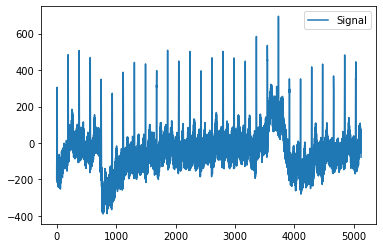

In [66]:
import matplotlib.pyplot as plt

ecg_signal = signals[0][ecg_ch].iloc[:freq*20]

_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=freq)

fig = plt.figure(figsize=(15,8))
nk.events_plot(rpeaks['ECG_R_Peaks'], ecg_signal)


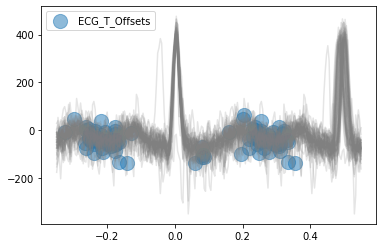

In [56]:
# Delineate the ECG signal
_, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=freq, method="peak")

# Visualize P-peaks and T-peaks
signal_peak, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=freq, method="peak", show=True, show_type='bounds_T')


<AxesSubplot:>

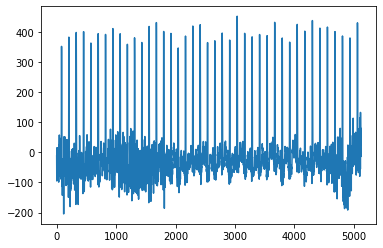

In [42]:

ecg_signal.plot()

In [35]:
waves

{'ECG_P_Peaks': [nan,
  173,
  296,
  386,
  511,
  629,
  747,
  912,
  1037,
  1118,
  1284,
  1353,
  1483,
  1622,
  1734,
  1851,
  1969,
  2096,
  2259,
  2383,
  2466,
  2628,
  2707,
  2835,
  3005,
  3130,
  3256,
  3335,
  3460,
  3635,
  3763,
  3842,
  4013,
  4099,
  4270,
  4396,
  4477,
  4644,
  4769,
  4900],
 'ECG_P_Onsets': [nan,
  167,
  291,
  382,
  507,
  605,
  739,
  909,
  1022,
  1113,
  1280,
  1347,
  1480,
  1618,
  1729,
  1840,
  1944,
  2066,
  2242,
  2369,
  2448,
  2614,
  2698,
  2815,
  2999,
  3116,
  3238,
  3323,
  3442,
  3624,
  3752,
  3828,
  4000,
  4091,
  4262,
  4385,
  4457,
  4635,
  4763,
  4895],
 'ECG_P_Offsets': [nan,
  186,
  303,
  392,
  517,
  639,
  768,
  915,
  1046,
  1123,
  1290,
  1361,
  1487,
  1627,
  1750,
  1866,
  1974,
  2104,
  2272,
  2392,
  2480,
  2637,
  2720,
  2855,
  3014,
  3147,
  3265,
  3350,
  3492,
  3645,
  3778,
  3847,
  4025,
  4108,
  4278,
  4409,
  4488,
  4663,
  4773,
  4910],
 'ECG_Q_Peaks